# CNN Speaker Recognition using Keras/TensorFlow
## Advanced ML Final Part 1
### By: Daniel Hill

#### Business Use Case:
This project is part of a MS in Business Analytics program. The intention of this assignment is to be applied to a business use case. For the business use case for Part 1 of my final, I will be setting up the following fake scenario:

A business has begun implementing a new system for recording meetings in light of the advances in AI. They are using a transcription tool after getting the recordings, and then feeding this through an LLM to give them a summary of the meeting. The next step of their AI meeting recording is that they would like to know who is speaking at what time. The company has recorded each of their employees saying 20 phrases. The first 10 phrases are all the same, and the second 10 are all different. The company would like to see if they can build a model on the 10 phrases that are the same to successfully identify the speaker in the second 10 phrases. 

The goal would be to have meetings recorded and automatically be able to categorize who is speaking. This way when the company goes back to review their meetings, they will know who said what at specific times. This will allow them to perform more granular text analysis, meeting summaries, and sentiment analysis.

#### This Notebook:

I will be reimplementing the code here: [Keras Speaker Recognition Example](https://keras.io/examples/audio/speaker_recognition_using_cnn/).

I'm using a different dataset. The dataset I'm using can be obtained here: [Voice-Based Human Identity Recognition Dataset](https://data.mendeley.com/datasets/zw4p4p7sdh/1).

In [53]:
# Uncomment to install the required packages:
# !pip install -r requirements.txt

In [54]:
# Uncomment to download the dataset
# !curl -O https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/zw4p4p7sdh-1.zip

In [55]:
# Uncomment to rename the zipped file
# !mv zw4p4p7sdh-1.zip AudioData.zip

In [56]:
# Uncomment to unzip the dataset after you download
# !unzip -qq AudioData.zip

In [57]:
# imports
import os
import shutil
import io
import subprocess

import numpy as np
import pandas as pd
import setuptools as _setuptools
import tensorflow as tf
import keras
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from pathlib import Path
from IPython.display import display, Audio
from pydub import AudioSegment
import soundfile as sf
import matplotlib.pyplot as plt

In the voice recognition dataset, they have a folder storing noise. Additionally, they have one repository of speaker data and they do a train-test split within that. I will be modifying this approach slightly.

## Setup

We will create some global variables that will be unchanged throughout the rest of the notebook.

In [58]:
# Define global variables where the data is stored
TRAIN_DATA_FOLDER = "AudioData/samePhrase"
TEST_DATA_FOLDER = "AudioData/differentPhrase"

# This was set to 1500 because there are 1500 samples in the
# example's dataset. This should be changed to the number of samples?
SAMPLING_RATE = 1500

# Seed to use when shuffling the dataset
SHUFFLE_SEED = 43

# Set batch size for
BATCH_SIZE = 128

# Set epochs for model training
EPOCHS = 1

## Dataset Generation

We need a few functions to be defined to help us get the data into the correct format.
- First, the data is currently in .flac files. The code example we are following expects everything as .wav files. We will create a function to modify this into .wav format.
- Second, we need to use the flac to wav function to iterate through all the files and convert them.
- Third, we need to read these into a TensorFlow usable format.
- Fourth we need to create data frames to store these usable formats.

In [59]:
# Step 1: Convert .flac to .wav
def convert_flac_to_wav(input_flac, output_wav):

    # Define the output directory
    output_dir = os.path.dirname(output_wav)

    # If the output directory does not exist, make it.
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Read the flac file.
    audio = AudioSegment.from_file(input_flac, format="flac")

    # Set sample width to 2 bytes (16 bits)
    audio = audio.set_sample_width(2)

    # Export the audio in .wav format.
    audio.export(output_wav, format="wav")

In [60]:
# Define the folder where the processed audio will live
final_folder = "AudioData"

# Set the folder to pull the unprocessed audio from
parent_folder = "A Dataset for Voice-Based Human Identity Recognition"

# Loop through the parent folder
for folder in os.listdir(parent_folder):

    # Ignore the speakers.csv file:
    if folder != "speakers.csv":

        # Join the parent folder to the current folder to creat the sub path
        sub_path = os.path.join(parent_folder, folder)

        # Loop through files in the subfolder
        for subfolder in os.listdir(sub_path):

            # Create a full path joining the subpath to the subfolder
            full_path = os.path.join(sub_path, subfolder)

            # Loop through the base level directory of audio files
            for file in os.listdir(full_path):

                # Create the most granular file path
                path_with_file = os.path.join(full_path, file)

                # Take off the end and append .wav instead of .flac
                final_file_name = file.split(".")[0]+".wav"

                # Use the convert function to convert the file to a wav file.
                convert_flac_to_wav(path_with_file, os.path.join(final_folder, folder, subfolder, final_file_name))

In [61]:
# Read and decode an audio file using tensorflow
def path_to_audio(path):
    """Reads and decodes an audio file."""
    # Read the file
    audio = tf.io.read_file(path)

    # Decode the audio using the sampling rate we defined before
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)

    # Return the raw audio file
    return audio

In [62]:
# Create a dataset of audio and labels
def paths_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""

    # Get the audio paths
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)

    # Create a dataset from these paths
    audio_ds = path_ds.map(
        lambda x: path_to_audio(x), num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Create a label dataset from the labels
    label_ds = tf.data.Dataset.from_tensor_slices(labels)

    return tf.data.Dataset.zip((audio_ds, label_ds))

In [63]:
def audio_to_fft(audio):
    
    # Since tf.signal.fft applies FFT on the innermost dimension,
    # we need to squeeze the dimensions and then expand them again
    # after FFT
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    # Return the absolute value of the first half of the FFT
    # which represents the positive frequencies
    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])

In [64]:
# Create the training class names by getting the list of folders within the training data folder
train_class_names = os.listdir(TRAIN_DATA_FOLDER)
print(
    "Train class names: {}".format(
        train_class_names,
    )
)

Train class names: ['135', '61', '95', '132', '59', '92', '66', '104', '50', '68', '103', '57', '150', '32', '35', '102', '69', '56', '105', '51', '58', '133', '67', '93', '134', '94', '60', '34', '33', '20', '18', '27', '9', '145', '11', '142', '7', '29', '16', '129', '42', '89', '116', '45', '111', '73', '118', '87', '127', '80', '74', '120', '6', '28', '143', '17', '144', '1', '10', '19', '26', '8', '21', '75', '81', '121', '119', '86', '72', '126', '44', '110', '43', '128', '88', '117', '38', '36', '31', '131', '91', '65', '136', '62', '96', '109', '100', '54', '107', '98', '138', '53', '30', '37', '39', '106', '99', '52', '139', '101', '55', '137', '97', '108', '63', '130', '64', '90', '46', '79', '112', '41', '115', '83', '77', '123', '48', '70', '84', '124', '24', '148', '23', '141', '4', '15', '3', '146', '12', '85', '71', '125', '76', '82', '49', '122', '40', '114', '47', '113', '78', '147', '2', '13', '5', '140', '14', '22', '149', '25']


In [65]:
# Get all labels and process the audio

# Initialize empty list to store path to audio
train_audio_paths = []

# Initialize empty list to store training set labels
train_labels = []

# Iterate through the training class names
for label, name in enumerate(train_class_names):

    # Create the final path
    dir_path = Path(TRAIN_DATA_FOLDER) / name

    # Create the path only if the file ends with .wav
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]

    # Add the sample paths to the end of the training audio paths
    train_audio_paths += speaker_sample_paths

    # Add the label to the labels for however many speaker paths there were
    train_labels += [label] * len(speaker_sample_paths)

# Summarize the process that was just done.
print(
    "Found {} files belonging to {} classes.".format(len(train_audio_paths), len(train_labels))
)


Found 1500 files belonging to 1500 classes.


In [66]:
# Get all testing labels and process the audio

# Initialize empty list to store path to test audio
test_audio_paths = []

# Initialize empty list to store testing set labels
test_labels = []

# Iterate through the training class names (still training because all the names are the same)
for label, name in enumerate(train_class_names):
    
    # Create the final path    
    dir_path = Path(TEST_DATA_FOLDER) / name

    # Create the path only if the file ends with .wav
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]

    # Add the sample paths to the end of the testing audio paths
    test_audio_paths += speaker_sample_paths

    # Add the label to the labels for however many speaker paths there were
    test_labels += [label] * len(speaker_sample_paths)

# Summarize the process that was just done.
print(
    "Found {} files belonging to {} classes.".format(len(test_audio_paths), len(train_class_names))
)

Found 1500 files belonging to 150 classes.


In [67]:
# Shuffle training set
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(train_audio_paths)

# Shuffle the training labels
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(train_labels)


# Shuffle testing set
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(test_audio_paths)

# Shuffle the testing labels
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(test_labels)

In [68]:
# Create 2 datasets, one for training and the other for validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = paths_and_labels_to_dataset(test_audio_paths, test_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)

In [69]:
# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

## Model Definition

In [70]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Add 1 dimensional convolutional layer
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)

    # Add as many convolutional layers as passed to conv_number
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)

# Build the model
def build_model(input_shape, num_classes):

    # Define input layer based on input shape
    inputs = keras.layers.Input(shape=input_shape, name="input")

    # Call residual block function to construct the model
    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    # Finalize the model by pooling and flattening, then feeding into 2 final dense layers.
    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    # Output predictions based on the number of classes
    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    # Return the constructed model
    return keras.models.Model(inputs=inputs, outputs=outputs)

In [88]:
# Build model based on the Sampling rate and number of classes
model = build_model((SAMPLING_RATE // 2, 1), len(train_class_names))

# Show a summary of the model
model.summary()

# Compile the model using Adam's default learning rate and categorical crossentropy
model.compile(
    optimizer="Adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model.keras"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 750, 1)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_55 (Conv1D)  │ (None, 750, 16)   │         64 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_39       │ (None, 750, 16)   │          0 │ conv1d_55[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_56 (Conv1D)  │ (None, 750, 16)   │        784 │ activation_39[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_54 (Conv1D)  │ (None, 750, 16)   │         32 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 750, 16)   │          0 │ conv1d_56[0][0],  │
│                     │                   │            │ conv1d_54[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_40       │ (None, 750, 16)   │          0 │ add_15[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_15    │ (None, 375, 16)   │          0 │ activation_40[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_58 (Conv1D)  │ (None, 375, 32)   │      1,568 │ max_pooling1d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_41       │ (None, 375, 32)   │          0 │ conv1d_58[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_59 (Conv1D)  │ (None, 375, 32)   │      3,104 │ activation_41[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_57 (Conv1D)  │ (None, 375, 32)   │        544 │ max_pooling1d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 375, 32)   │          0 │ conv1d_59[0][0],  │
│                     │                   │            │ conv1d_57[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_42       │ (None, 375, 32)   │          0 │ add_16[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 187, 32)   │          0 │ activation_42[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_61 (Conv1D)  │ (None, 187, 64)   │      6,208 │ max_pooling1d_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_43       │ (None, 187, 64)   │          0 │ conv1d_61[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_62 (Conv1D)  │ (None, 187, 64)   │     12,352 │ activation_43[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_44       │ (None, 187, 64)   │          0 │ conv1d_62[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_63 (Conv1D)  │ (None, 187, 64)   │     12,352 │ activation_44[0]

 Total params: 616,934 (2.35 MB)

 Trainable params: 616,934 (2.35 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [89]:
# Remove callbacks so the model will run for all 50 epochs.
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=valid_ds,
    #callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - accuracy: 0.0071 - loss: 4.9947 - val_accuracy: 0.0133 - val_loss: 5.0163
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - accuracy: 0.0182 - loss: 4.9167 - val_accuracy: 0.0193 - val_loss: 4.9782
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 266ms/step - accuracy: 0.0214 - loss: 4.8237 - val_accuracy: 0.0220 - val_loss: 4.8286
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step - accuracy: 0.0247 - loss: 4.6984 - val_accuracy: 0.0167 - val_loss: 4.7264
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.0351 - loss: 4.5481 - val_accuracy: 0.0300 - val_loss: 4.6879
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - accuracy: 0.0409 - loss: 4.4521 - val_accuracy: 0.0307 - val_loss: 4.6134
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step - accuracy: 0.0387 - loss: 4.4282 - val_accuracy: 0.0233 - val_loss: 4.5279
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step - accuracy: 0.0544 - loss: 4.3057 - val_accu

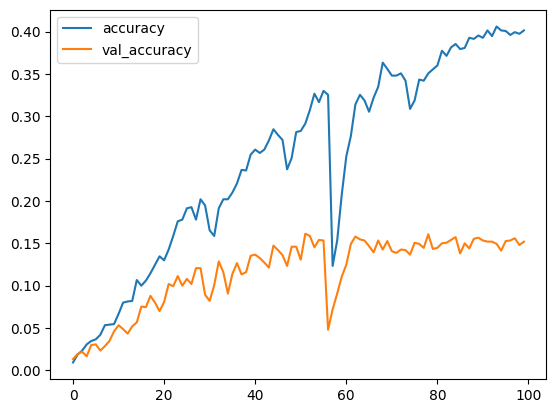

In [90]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()

Show the most misclassified cases:

In [99]:
train_preds = model.predict(train_ds).argmax(axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


In [101]:
from collections import Counter

# Find misclassified instances
misclassified = [(true, pred) for true, pred in zip(train_preds, train_labels) if true != pred]

# Count most frequent misclassifications
misclass_counter = Counter(misclassified)
most_common_misclass = misclass_counter.most_common(10)

# Display most common misclassifications
for (true, pred), count in most_common_misclass:
    print(f"Class {true} misclassified as {pred}: {count} times")

Class 6 misclassified as 91: 8 times
Class 6 misclassified as 2: 7 times
Class 28 misclassified as 1: 6 times
Class 6 misclassified as 19: 6 times
Class 28 misclassified as 38: 6 times
Class 6 misclassified as 48: 6 times
Class 28 misclassified as 105: 6 times
Class 6 misclassified as 94: 6 times
Class 6 misclassified as 108: 6 times
Class 6 misclassified as 146: 6 times


Show loss and accuracy on the validation set:

In [102]:
print(model.evaluate(valid_ds))

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1580 - loss: 14.5220
[10.12694263458252, 0.15199999511241913]


While 15% accuracy isn't great, I found it impressive that the model performed this well. There are 150 classes, where the training data was all people only saying "Machine Learning 1, 2, 3, 4, 5" and the testing data contained many different phrases. It would be interesting to try this the other way around. What I did as the testing data was probably better to train on and harder to predict. In the example we were following, they only used 5 voices. It would require us to build a more complex or custom model, or even collect more data from out 150 subjects to be able to get this accuracy much higher.

## Demonstration

In [104]:
# Set number of samples total to display
SAMPLES_TO_DISPLAY = 10

# Create testing data
test_ds = paths_and_labels_to_dataset(test_audio_paths, test_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

# Iterate through and display the audio for the 10 random samples that were selected.
for audios, labels in test_ds.take(1):
    # Get the signal FFT
    ffts = audio_to_fft(audios)
    # Predict
    y_pred = model.predict(ffts)
    # Take random samples
    rnd = np.random.randint(0, BATCH_SIZE, SAMPLES_TO_DISPLAY)
    audios = audios.numpy()[rnd, :, :]
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(SAMPLES_TO_DISPLAY):
        # For every sample, print the true and predicted label
        # as well as run the voice with the noise
        print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if labels[index] == y_pred[index] else "[91m",
                train_class_names[labels[index]],
                "[92m" if labels[index] == y_pred[index] else "[91m",
                train_class_names[y_pred[index]],
            )
        )
        display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Speaker: 116	Predicted: 66


Speaker: 99	Predicted: 51


Speaker: 55	Predicted: 55


Speaker: 75	Predicted: 33


/Users/danielhill/Documents/AdvancedMachineLearningFinal/.venv/lib/python3.12/site-packages/IPython/lib/display.py:187: RuntimeWarning: invalid value encountered in divide
  scaled = data / normalization_factor * 32767
/Users/danielhill/Documents/AdvancedMachineLearningFinal/.venv/lib/python3.12/site-packages/IPython/lib/display.py:188: RuntimeWarning: invalid value encountered in cast
  return scaled.astype("<h").tobytes(), nchan


Speaker: 111	Predicted: 16


Speaker: 40	Predicted: 66


Speaker: 138	Predicted: 138


Speaker: 9	Predicted: 33


Speaker: 45	Predicted: 66


Speaker: 99	Predicted: 139


2024-06-08 17:32:38.617540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


After listening to these sounds that were either miscategorized or categorized correctly, I can understand why the algorithm may have a hard time picking up who was who.